In [4]:
from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Union

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.utils.tensorboard
from torch import Tensor
from tqdm import tqdm

import delu

import sys
import os
os.environ['PROJECT_DIR'] = '/Users/timgritsaev/Desktop/tabular/tabular-hpo'
sys.path.append('/Users/timgritsaev/Desktop/tabular/tabular-hpo')
import lib
from lib import KWArgs

import json

from loss_landscapes.metrics.metric import Metric
from loss_landscapes.model_interface.model_wrapper import ModelWrapper


import loss_landscapes
import loss_landscapes.metrics
import copy
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import matplotlib as mlp
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
plt.rcParams['savefig.format'] = 'pdf'
SMALL_SIZE = 7
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE) 
mlp.rcParams.update({"axes.grid" : True, "grid.color": "white"})
%matplotlib inline

@dataclass(frozen=True)
class Config:
    seed: int
    data: Union[lib.Dataset[np.ndarray], KWArgs]  # lib.data.build_dataset
    model: Union[nn.Module, KWArgs]  # Model
    optimizer: Union[torch.optim.Optimizer, KWArgs]  # lib.deep.make_optimizer
    batch_size: int
    patience: Optional[int]
    n_epochs: Union[int, float]


def _patch_config(c: lib.JSONDict):
    # update config format
    if isinstance(c['model'], dict) and 'backbone' not in c['model']:
        assert 'num_embeddings' in c
        c['model'] = {
            'num_embeddings': c.pop('num_embeddings'),
            'backbone': c.pop('model'),
        }
        

def create_all(path_to_config, path_to_model1, path_to_model2, path_to_start_model=None, steps=10, distance=0.001):

    class Model(nn.Module):
        def __init__(
            self,
            *,
            n_num_features: int,
            n_bin_features: int,
            cat_cardinalities: list[int],
            n_classes: Optional[int],
            num_embeddings: Optional[dict],  # lib.deep.ModuleSpec
            backbone: dict,  # lib.deep.ModuleSpec
        ) -> None:
            assert n_num_features or n_bin_features or cat_cardinalities
            if num_embeddings is not None:
                assert n_num_features
            assert backbone['type'] in ['MLP', 'ResNet']
            super().__init__()

            if num_embeddings is None:
                self.m_num = nn.Identity() if n_num_features else None
                d_num = n_num_features
            else:
                self.m_num = lib.make_module(num_embeddings, n_features=n_num_features)
                d_num = n_num_features * num_embeddings['d_embedding']
            self.m_bin = nn.Identity() if n_bin_features else None
            self.m_cat = lib.OneHotEncoder(cat_cardinalities) if cat_cardinalities else None
            self.backbone = lib.make_module(
                backbone,
                d_in=d_num + n_bin_features + sum(cat_cardinalities),
                d_out=lib.get_d_out(n_classes),
            )
            self.flat = True

        def forward(
            self,
            *,
            x_num: Optional[Tensor],
            x_bin: Optional[Tensor],
            x_cat: Optional[Tensor],
        ) -> Tensor:
            x = []
            for module, x_ in [
                (self.m_num, x_num),
                (self.m_bin, x_bin),
                (self.m_cat, x_cat),
            ]:
                if x_ is None:
                    assert module is None
                else:
                    assert module is not None
                    x.append(module(x_))
            del x_  # type: ignore[code]
            if self.flat:
                x = torch.cat([x_.flatten(1, -1) for x_ in x], dim=1)
            else:
                # for Transformer-like backbones (currently unsupported)
                assert all(x_.ndim == 3 for x_ in x)
                x = torch.cat(x, dim=1)

            x = self.backbone(x)
            return x
        

    class Model__(nn.Module):
        def __init__(
            self,
            *,
            n_num_features: int,
            n_bin_features: int,
            cat_cardinalities: list[int],
            n_classes: Optional[int],
            num_embeddings: Optional[dict],  # lib.deep.ModuleSpec
            backbone: dict,  # lib.deep.ModuleSpec
        ) -> None:
            assert n_num_features or n_bin_features or cat_cardinalities
            if num_embeddings is not None:
                assert n_num_features
            assert backbone['type'] in ['MLP', 'ResNet']
            super().__init__()

            if num_embeddings is None:
                self.m_num = nn.Identity() if n_num_features else None
                d_num = n_num_features
            else:
                self.m_num = lib.make_module(num_embeddings, n_features=n_num_features)
                d_num = n_num_features * num_embeddings['d_embedding']
            self.m_bin = nn.Identity() if n_bin_features else None
            self.m_cat = lib.OneHotEncoder(cat_cardinalities) if cat_cardinalities else None
            self.backbone = lib.make_module(
                backbone,
                d_in=d_num + n_bin_features + sum(cat_cardinalities),
                d_out=lib.get_d_out(n_classes),
            )
            self.flat = True
            self.current_dataset = 'train'

        def forward(
            self,
            X
        ) -> Tensor:
            x = []
            x_num = None if dataset.X_num is None else dataset.X_num[self.current_dataset][X]
            x_bin = None if dataset.X_bin is None else dataset.X_bin[self.current_dataset][X]
            x_cat = None if dataset.X_cat is None else dataset.X_cat[self.current_dataset][X]
            for module, x_ in [
                (self.m_num, x_num),
                (self.m_bin, x_bin),
                (self.m_cat, x_cat),
            ]:
                if x_ is None:
                    assert module is None
                else:
                    assert module is not None
                    x.append(module(x_))
            del x_  # type: ignore[code]
            if self.flat:
                x = torch.cat([x_.flatten(1, -1) for x_ in x], dim=1)
            else:
                # for Transformer-like backbones (currently unsupported)
                assert all(x_.ndim == 3 for x_ in x)
                x = torch.cat(x, dim=1)

            x = self.backbone(x)
            return x
        
        
    def apply_model(part, idx):
        return model(
            x_num=None if dataset.X_num is None else dataset.X_num[part][idx],
            x_bin=None if dataset.X_bin is None else dataset.X_bin[part][idx],
            x_cat=None if dataset.X_cat is None else dataset.X_cat[part][idx],
        ).squeeze(-1)
        
        
    def apply_model__(part, idx):
        model.current_dataset = part
        return model(idx).squeeze(-1)


    def are_valid_predictions(predictions: dict[str, np.ndarray]) -> bool:
        return all(np.isfinite(x).all() for x in predictions.values())
        
        
    @torch.inference_mode()
    def evaluate(parts: list[str], eval_batch_size: int):
        model.eval()
        predictions = {}
        for part in parts:
            while eval_batch_size:
                try:
                    predictions[part] = (
                        torch.cat(
                            [
                                apply_model__(part, idx)
                                for idx in torch.arange(
                                    dataset.size(part), device=device
                                ).split(eval_batch_size)
                            ]
                        )
                        .cpu()
                        .numpy()
                    )
                except RuntimeError as err:
                    if not lib.is_oom_exception(err):
                        raise
                    eval_batch_size //= 2
                    # logger.warning(f'eval_batch_size = {eval_batch_size}')
                else:
                    break
            if not eval_batch_size:
                RuntimeError('Not enough memory even for eval_batch_size=1')
        metrics = (
            dataset.calculate_metrics(predictions, report['prediction_type'])
            if are_valid_predictions(predictions)
            else {x: {'score': -999999.0} for x in predictions}
        )
        return metrics, predictions, eval_batch_size


    class TrainLoss(Metric):
        """ Computes a specified loss function over specified input-output pairs. """
        def __init__(self, loss_fn, ids: torch.Tensor):
            super().__init__()
            self.loss_fn = loss_fn
            self.ids = ids

        def __call__(self, model_wrapper: ModelWrapper) -> float:
            # model_wrapper.current_dataset = 'val'
            # loss = self.loss_fn(model_wrapper.forward(torch.arange(dataset.size('val'))).squeeze(-1), val_y).item()
            model_wrapper.current_dataset = 'train'
            loss = self.loss_fn(model_wrapper.forward(torch.arange(dataset.size('train'))).squeeze(-1), train_y).item()
            # model_wrapper.current_dataset = 'train'
            return loss
        
        
    class ValLoss(Metric):
        """ Computes a specified loss function over specified input-output pairs. """
        def __init__(self, loss_fn, ids: torch.Tensor):
            super().__init__()
            self.loss_fn = loss_fn
            self.ids = ids

        def __call__(self, model_wrapper: ModelWrapper) -> float:
            model_wrapper.current_dataset = 'val'
            loss = self.loss_fn(model_wrapper.forward(torch.arange(dataset.size('val'))).squeeze(-1), val_y).item()
            model_wrapper.current_dataset = 'train'
            return loss
        
        
    class TestLoss(Metric):
        """ Computes a specified loss function over specified input-output pairs. """
        def __init__(self, loss_fn, ids: torch.Tensor):
            super().__init__()
            self.loss_fn = loss_fn
            self.ids = ids

        def __call__(self, model_wrapper: ModelWrapper) -> float:
            model_wrapper.current_dataset = 'test'
            loss = self.loss_fn(model_wrapper.forward(torch.arange(dataset.size('test'))).squeeze(-1), test_y).item()
            model_wrapper.current_dataset = 'train'
            return loss
        
    if path_to_config[-2:] == "pt":
        config = torch.load(path_to_config)['report']['best']['config']
    else:
        file_in = open(path_to_config, "r")
        config = json.loads(file_in.read())
    # print(config)
    _patch_config(config)
    C = lib.make_config(Config, config)
    report = lib.create_report(config)

    delu.improve_reproducibility(C.seed)
    device = lib.get_device()

    dataset = (C.data if isinstance(C.data, lib.Dataset) else lib.build_dataset(**C.data)).to_torch(device)

    loss_fn = lib.get_loss_fn(dataset.task_type)

    model1 = Model__(
                n_num_features=dataset.n_num_features,
                n_bin_features=dataset.n_bin_features,
                cat_cardinalities=dataset.cat_cardinalities(),
                n_classes=dataset.n_classes(),
                **C.model,
            )
    model1.load_state_dict(torch.load(path_to_model1))
    model1.eval()
    
    model2 = Model__(
                n_num_features=dataset.n_num_features,
                n_bin_features=dataset.n_bin_features,
                cat_cardinalities=dataset.cat_cardinalities(),
                n_classes=dataset.n_classes(),
                **C.model,
            )
    model2.load_state_dict(torch.load(path_to_model2))
    model2.eval()

    # os.system('clear')

    report['n_parameters'] = lib.get_n_parameters(model1)
    report['prediction_type'] = None if dataset.is_regression else 'logits'
    
    train_model1 = copy.deepcopy(model1)
    train_model1.current_dataset = 'train'
    train_model2 = copy.deepcopy(model2)
    train_model2.current_dataset = 'train'
     
    val_model1 = copy.deepcopy(model1)
    val_model1.current_dataset = 'val'
    val_model2 = copy.deepcopy(model2)
    val_model2.current_dataset = 'val'
    # test_model = copy.deepcopy(model)
    # test_model.current_dataset = 'test'

    train_x = iter(delu.data.make_index_dataloader(dataset.size('train'), C.batch_size, shuffle=False)).__next__()
    val_x = iter(delu.data.make_index_dataloader(dataset.size('train'), C.batch_size, shuffle=False)).__next__()
    # val_x = iter(delu.data.make_index_dataloader(dataset.size('val'), C.batch_size, shuffle=False)).__next__()
    # test_x = iter(delu.data.make_index_dataloader(dataset.size('test'), C.batch_size, shuffle=False)).__next__()

    train_y = dataset.Y['train'].to(torch.long if dataset.is_multiclass else torch.float)
    val_y = dataset.Y['val'].to(torch.long if dataset.is_multiclass else torch.float)
    # test_y = dataset.Y['test'].to(torch.long if dataset.is_multiclass else torch.float)
    print(train_y[:10])
    # print(val_y[:10])
    # print(test_y[:10])

    train_metric = TrainLoss(loss_fn, train_x)
    val_metric = ValLoss(loss_fn, val_x)
    # test_metric = TestLoss(loss_fn, test_x)
    
    train_loss_data = loss_landscapes.linear_interpolation(train_model1, train_model2, train_metric, steps, deepcopy_model=True)
    train_loss_data = (train_loss_data ** 0.5) if loss_fn is torch.nn.functional.mse_loss else train_loss_data
    val_loss_data = loss_landscapes.linear_interpolation(val_model1, val_model2, val_metric, steps, deepcopy_model=True)
    val_loss_data = (val_loss_data ** 0.5) if loss_fn is torch.nn.functional.mse_loss else val_loss_data
    
    plt.plot([1. / steps * i for i in range(steps)], train_loss_data, label='train')
    plt.plot([1. / steps * i for i in range(steps)], val_loss_data, label='val')
    plt.xlabel('Коэффициент интерполяции')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()
    plt.savefig(f"images/mode_connectivity2d")

/Users/timgritsaev/Desktop/tabular/tabular-hpo/lib/util.py:237: UserWarning: The key "function" will be missing in the report. Reason: '/private/var/folders/65/1vwp97n52f5bhqv1kd377bw40000gn/T/ipykernel_5596/3696247013.py' is not in the subpath of '/Users/timgritsaev/Desktop/tabular/tabular-hpo' OR one path is relative and the other is absolute.
  warnings.warn(
0:01:04 | Using cached features: build_dataset__california__quantile__None__standard__0__f7706b82c7264c3b33fedc53664ebacf.pickle


----------------------------------------------------------------------------------------------------
{'seed': 0,
 'data': {'seed': 0,
          'cache': True,
          'path': ':data/california',
          'num_policy': 'quantile',
          'cat_policy': None,
          'y_policy': 'standard'},
 'model': {'num_embeddings': None,
           'backbone': {'type': 'MLP',
                        'n_blocks': 2,
                        'd_layer': 238,
                        'dropout': 0.23395140372463127,
                        'activation': 'ReLU'}},
 'optimizer': {'type': 'AdamW', 'lr': 0.0009213130217887258, 'weight_decay': 3.911847192982179e-05},
 'batch_size': 256,
 'patience': 16,
 'n_epochs': inf}
----------------------------------------------------------------------------------------------------
tensor([-0.4376,  0.5515, -1.1364,  0.5171, -0.5695,  0.0457,  1.8362, -0.8185,
         0.7238, -1.2200])


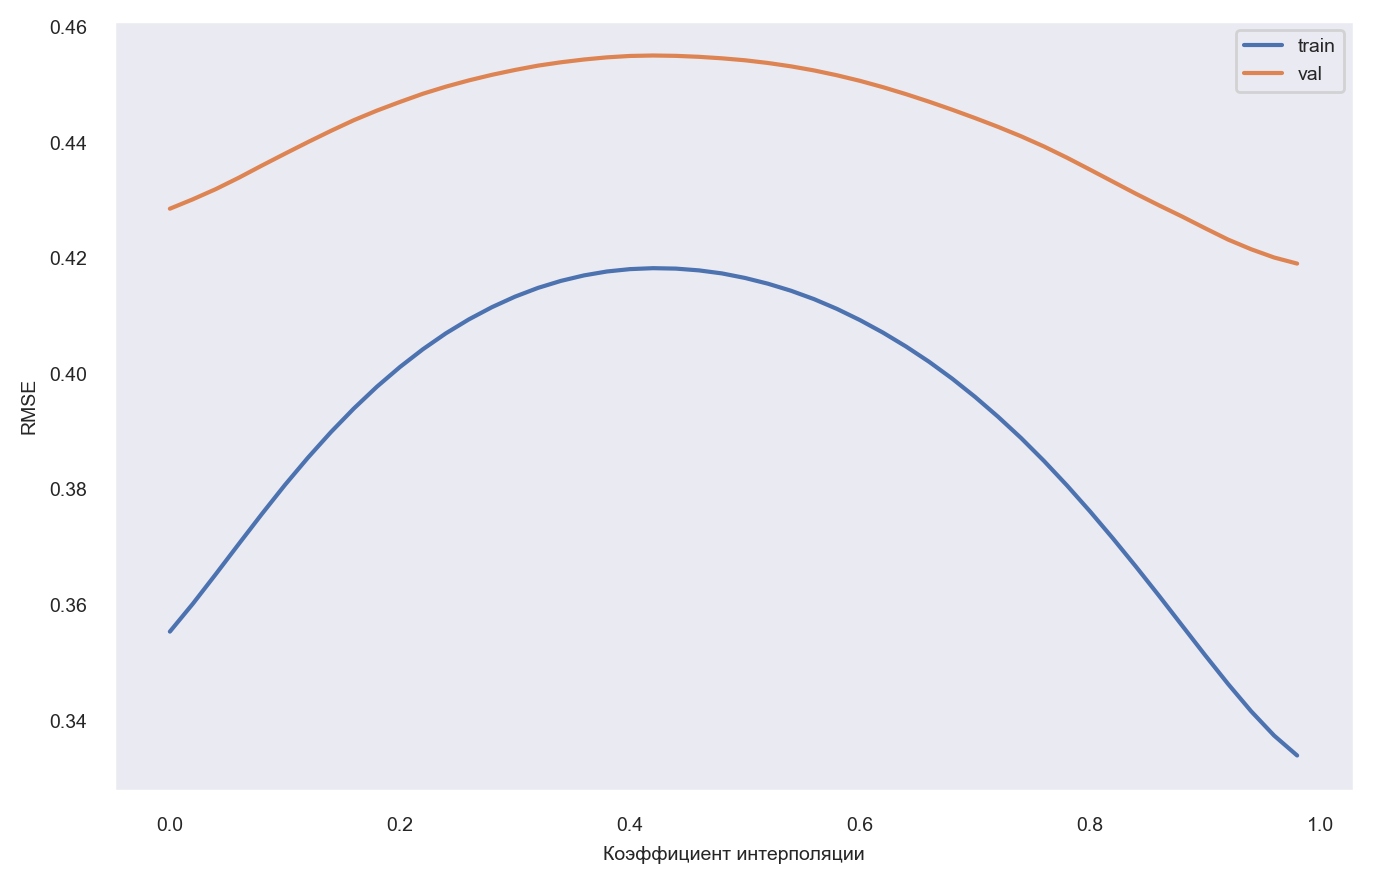

<Figure size 800x500 with 0 Axes>

In [5]:
DATASET = 'california'
path_to_config = '/Users/timgritsaev/Desktop/tabular/tabular-hpo/exp/mlp/' + DATASET + '/0-tuning/checkpoint.pt'
path_to_model1 = '/Users/timgritsaev/Desktop/tabular/tabular-hpo/saved_models/optuna_' + DATASET + '_0.pt'
path_to_model2 = '/Users/timgritsaev/Desktop/tabular/tabular-hpo/saved_models/optuna_' + DATASET + '_0-1.pt'
create_all(path_to_config, path_to_model1, path_to_model2, steps=50, distance=0.1)